# Guided Backprop Visualization

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, WeightedRandomSampler
from torchvision import transforms, models
from torchvision.models import EfficientNet_V2_S_Weights
from PIL import Image
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json
import numpy as np
import os
import csv
from torch.optim.lr_scheduler import ReduceLROnPlateau
from tqdm.notebook import tqdm
from torchsummary import summary


class TestDataset(Dataset):
    def __init__(self, csv_file, img_dir, transform=None):
        self.test_data = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.test_data)

    def __getitem__(self, idx):
        img_name = str(self.test_data.iloc[idx, 0])  # Assuming the image ID is in the first column
        img_path = os.path.join(self.img_dir, img_name)
        if not os.path.exists(img_path):
            img_path = os.path.join(self.img_dir, f"{img_name}.jpg")
        
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)

        return image, img_name



class StabilityPredictor(nn.Module):
    def __init__(self, num_classes=6):
        super(StabilityPredictor, self).__init__()
        weights = EfficientNet_V2_S_Weights.DEFAULT
        self.efficientnet = models.efficientnet_v2_s(weights=weights)
        num_ftrs = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(num_ftrs, num_classes)
        )

    def forward(self, x):
        return self.efficientnet(x)
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = StabilityPredictor(num_classes=6)
model.to(device)
model.load_state_dict(torch.load('stability_predictor_efficientnetv2_classification_augmented.pth', map_location=torch.device('cpu')))


<All keys matched successfully>

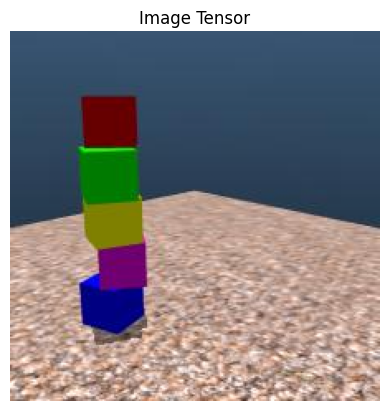

In [35]:
# Load pre-calculated dataset statistics
stats = torch.load('dataset_stats.pth')
mean, std = stats['mean'], stats['std']

# Create transform for test set
test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist()),
])

# Create test dataset and dataloader
test_dataset = TestDataset(
    csv_file='./COMP90086_2024_Project_test/test.csv',
    img_dir='./COMP90086_2024_Project_test/test',
    transform=test_transform
)

img_tensor = test_dataset[0]

# Display img_tensor as an image
img_tensor_display = img_tensor[0].permute(1, 2, 0)  # Convert from CHW to HWC format
img_tensor_display = img_tensor_display * torch.tensor(std).view(1, 1, 3) + torch.tensor(mean).view(1, 1, 3)  # Denormalize
img_tensor_display = img_tensor_display.numpy()

plt.imshow(img_tensor_display)
plt.title('Image Tensor')
plt.axis('off')
plt.show()

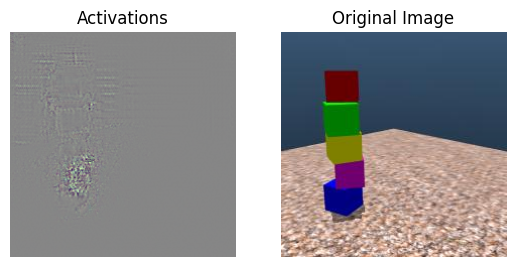

In [32]:
import torch
import torch.nn as nn

# Custom ReLU to override the backward pass
class GuidedReLU(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        # Standard ReLU forward pass
        ctx.save_for_backward(input)
        return torch.clamp(input, min=0)

    @staticmethod
    def backward(ctx, grad_output):
        # Only pass positive gradients back
        input, = ctx.saved_tensors
        grad_input = grad_output.clone()
        grad_input[input <= 0] = 0
        grad_output[grad_output <= 0] = 0
        return grad_input

# Register hooks to replace ReLU activations in your model
def replace_relu_with_guided_relu(model):
    for name, module in model.named_modules():
        if isinstance(module, nn.ReLU):
            model._modules[name] = GuidedReLU.apply

def guided_backprop(model, input_image, target_class):
    # Set model to evaluation mode
    model.eval()

    # Enable gradient calculation on the input image
    input_image.requires_grad = True

    # Forward pass
    output = model(input_image)

    # Zero gradients
    model.zero_grad()

    # Get the score for the target class
    score = output[0, target_class]

    # Backward pass to compute the gradients
    score.backward()

    # Get the gradients from the input image
    gradients = input_image.grad.data

    return gradients

def visualize_guided_backprop(gradients):
    # Convert gradients to numpy array
    gradients = gradients.detach().cpu().numpy()[0]

    # Normalize the gradients to [0, 1]
    gradients = (gradients - gradients.min()) / (gradients.max() - gradients.min())

    # Plot the gradients
    plt.subplot(1,2,1)
    plt.imshow(np.transpose(gradients, (1, 2, 0)))  # Convert from CHW to HWC format
    plt.axis('off')
    plt.title('Activations')

    plt.subplot(1,2,2)
    plt.imshow(img_tensor_display)
    plt.axis('off')
    plt.title('Original Image')
    
    plt.show()
    



model.eval()

# Replace all ReLUs with GuidedReLU
replace_relu_with_guided_relu(model)




img_name = "COMP90086_2024_Project_train/train/2670.jpg"
img_size = (224,224) # default input shape has to be (224, 224, 3)


# Load and preprocess your input image (as a torch tensor)
img = img_tensor[0].unsqueeze(0)

img = img.clone().detach().requires_grad_(True)


# Run guided backpropagation for a specific class (e.g., class index 1)
target_class = 1
gradients = guided_backprop(model, img, target_class)

# Visualize the results
visualize_guided_backprop(gradients)